In [120]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torchaudio as T
import IPython.display as ipd
from IPython.core.display import display
from model import UNet

from inference import SDESampling, SDESampling2, ODESampling, ScipySolver, DDIMSampling, ForwardODESampling, \
        ForwardDDIMSampling, SDEInpainting
from sde import SDE, VpSdeSigmoid, VpSdeCos, SubVpSdeCos, GeneralizedSubVpSdeCos

T.set_audio_backend('sox')
device=torch.device('cuda:0')
#model_dir = os.getcwd() + '/saved_weights/weights_vp_sigmoid.pt'
model_dir = os.getcwd() + '/saved_weights/weights_vp.pt'
#model_dir = os.getcwd() + '/saved_weights/weights_subvp.pt'

checkpoint = torch.load(model_dir)
model = UNet().to(device)
#model.load_state_dict(checkpoint['model'])
model.load_state_dict(checkpoint['ema_weights'])
model.eval()

def load_to_device(path, size):
    audio, sr = T.load(path)
    audio = audio[:, :size]
    audio = audio.to(device)
    return audio

def plot_and_hear(audio):
    display(ipd.Audio(audio.cpu(), rate=44100))
    plt.plot(audio.cpu().t().numpy())
    

sns.set()


/home/simon/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/torchaudio/backend/utils.py:59: UserWarning: "sox" backend is deprecated and will be removed in 0.9.0. Please use "sox_io" backend.
  warnings.warn(


# SDE Sampling

In [121]:
sde = VpSdeCos()

In [122]:
class SDESampling3:
    def __init__(self, model, sde):
        self.model = model
        self.sde = sde

    def create_schedules(self, nb_steps):
        t_schedule = torch.arange(1, nb_steps + 1) / nb_steps
        t_schedule = (self.sde.t_max - self.sde.t_min) * \
            t_schedule + self.sde.t
        dt = t_schedule[1] - t_schedule[0]
        sigma_schedule = self.sde.sigma(t_schedule)
        beta_schedule = self.sde.beta(t_schedule)
        g_schedule = self.sde.g(t_schedule)

        return t_schedule[0], sigma_schedule, beta_schedule, g_schedule, dt

    def predict(
        self,
        audio,
        nb_steps
    ):

        with torch.no_grad():
            audio_cat = audio.clone()

            t_0, sigma, beta, g, dt = self.create_schedules(nb_steps)

            for n in range(nb_steps - 2, 0, -1):
                # begins at t = 1 (n = nb_steps - 1)
                # stops at t = 2/nb_steps (n=1)
                if n > 40:  # everytime

                    audio = (1 + dt * beta[n]/2) * audio - dt * (g[n])**2 / sigma[n] * \
                        self.model(audio, sigma[n])

                    noise = torch.randn_like(audio)
                    audio += g[n] * dt**0.5 * noise
                    audio_cat = torch.cat([audio, audio_cat])
                else:
                    audio = (1 + dt * beta[n]/2) * audio - dt * (g[n])**2 / (2*sigma[n]) * \
                        self.model(audio, sigma[n])
                    audio_cat = torch.cat([audio, audio_cat])

            # The noise level is now sigma(1/nb_steps) = sigma[0]
            # Jump step
            audio = (audio - sigma[0] * self.model(audio,
                                                   sigma[0])) / self.sde.mean(t_0)
            audio_cat = torch.cat([audio, audio_cat])

        return audio_cat, sigma, beta, g**2/sigma



In [123]:
sde_sampling = SDESampling3(model, sde)

In [124]:
audio = torch.randn(1, 21000, device=device)

In [125]:
audio_sde, sigma, beta, g2_ov_s = sde_sampling.predict(audio, 300)
#audio_sde = torch.cat([audio_sde[k] for k in range(10)], axis=0)

In [126]:
sigma_ob = audio_sde[:,18000:].std(axis=1).cpu()

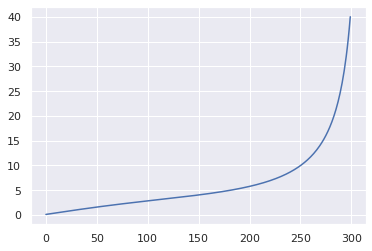

In [129]:
plt.plot(g2_ov_s)

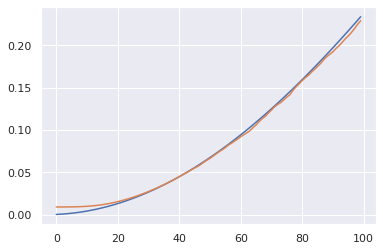

In [127]:
k=100
plt.plot(sigma[:k])
plt.plot(sigma_ob[:k])

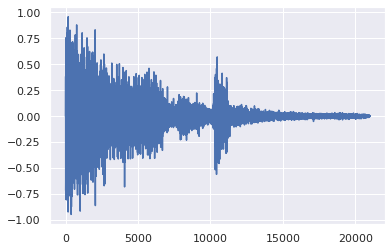

In [128]:
plot_and_hear(audio_sde[0])

# SDE Sampling 2

In [28]:
sde_sampling2 = SDESampling2(model, sde)

In [29]:
audio = torch.randn(10, 21000, device=device)

In [30]:
audio_sde2 = sde_sampling.predict(audio, 300)
audio_sde2 = torch.cat([audio_sde2[k] for k in range(10)], axis=0)

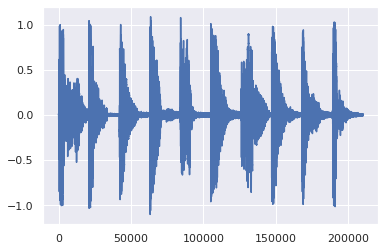

In [31]:
plot_and_hear(audio_sde2)

# ODE Sampling

In [10]:
ode_sampling = ODESampling(model, sde)

In [7]:
audio = torch.randn(10, 21000, device=device)

In [8]:
audio_ode = ode_sampling.predict(audio, 300)
audio_ode = torch.cat([audio_ode[k] for k in range(10)], axis=0)

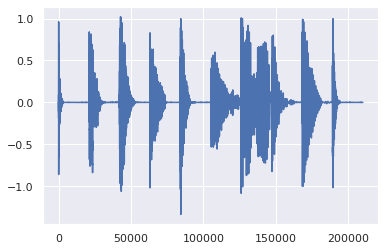

In [9]:
plot_and_hear(audio_ode)

# DDIM Solver

In [15]:
ddim_sampling = DDIMSampling(model, sde)

In [20]:
audio_ddim = ddim_sampling.predict(audio, 20)
audio_ddim = torch.cat([audio_ddim[k] for k in range(10)], axis=0)

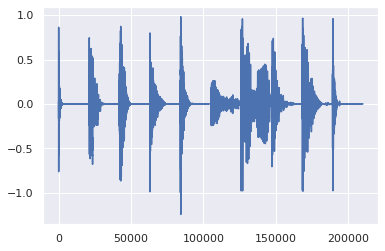

In [21]:
plot_and_hear(audio_ddim)

# Forward + Backward ODE Sampling

In [6]:
Fode = ForwardODESampling(model, sde)
ode_sampling = ODESampling(model, sde)

In [7]:
filenames = glob('/home/simon/workspace/datasets/drums_preprocessed/test/**/*.wav', recursive=True)


In [8]:
n = random.randint(0, len(filenames))
print(filenames[n])
drum = load_to_device(filenames[n], 21000)

/home/simon/workspace/datasets/drums_preprocessed/test/hats/subdir1095/109463-TBD-HHK-371.wav


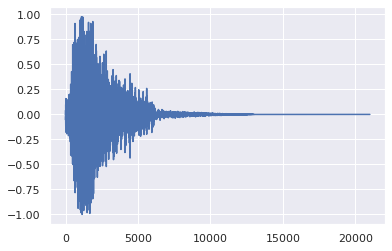

In [145]:
plot_and_hear(drum)

In [146]:
latent = Fode.predict(drum, 300)

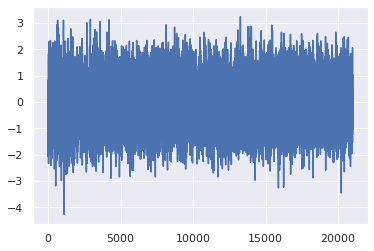

In [49]:
plot_and_hear(latent)

Now, let's compute the reconstruction with the ODE Sampling

In [147]:
reconstruction = ode_sampling.predict(latent, 300)


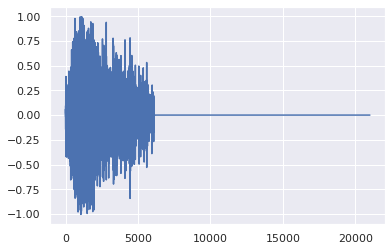

In [148]:
plot_and_hear(reconstruction)

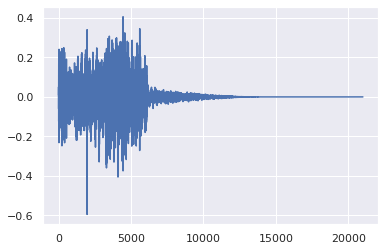

In [149]:
plot_and_hear(drum2-reconstruction)

# Forward + Backward DDIM Sampling

In [15]:
Fddim = ForwardDDIMSampling(model, sde)
ddim_sampling = DDIMSampling(model, sde)

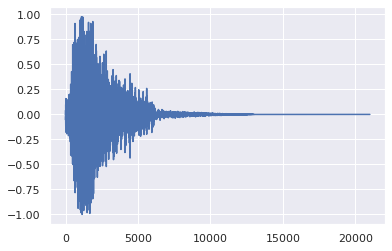

In [134]:
plot_and_hear(drum2)

In [139]:
latent_ddim = Fddim.predict(drum2, 300)

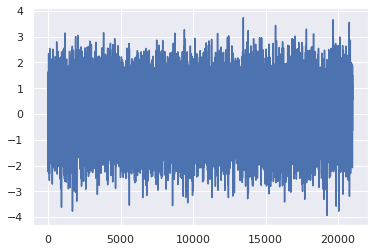

In [140]:
plot_and_hear(latent_ddim)

In [141]:
reconstructed_ddim = ddim_sampling.predict(latent_ddim, 300)

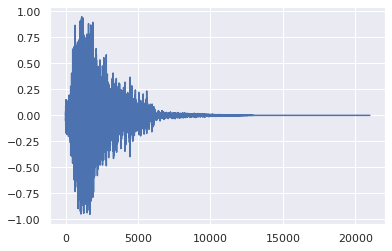

In [142]:
plot_and_hear(reconstructed_ddim)

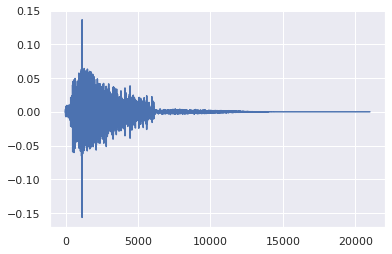

In [144]:
plot_and_hear(reconstructed_ddim-drum2)

# DDIM Interpolation

In [185]:
Fddim = ForwardDDIMSampling(model, sde)
ddim_sampling = DDIMSampling(model, sde)

In [190]:
filenames = glob('/home/simon/workspace/datasets/drums_preprocessed/test/**/*.wav', recursive=True)
n = random.randint(0, len(filenames))
m = random.randint(0, len(filenames))
print(filenames[n], filenames[m])
drum1 = load_to_device(filenames[n], 21000)
drum2 = load_to_device(filenames[m], 21000)

/home/simon/workspace/datasets/drums_preprocessed/test/hats/subdir1172/117186-THH-08052.wav /home/simon/workspace/datasets/drums_preprocessed/test/kicks/subdir1067/106686-WA_Short_Kick5.wav


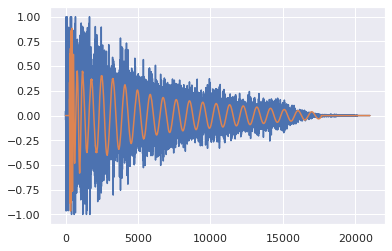

In [197]:
plot_and_hear(drum1)
plot_and_hear(drum2)

In [192]:
latent1 = Fddim.predict(drum1, 300)
latent2 = Fddim.predict(drum2, 300)

In [193]:
def create_latent_mix(lamb, latent1, latent2):
    lamb = np.cos(np.pi*lamb/2)
    return lamb * latent1 + (1-lamb**2)**0.5 * latent2


In [198]:
mix_drum = torch.cat([ddim_sampling.predict(create_latent_mix(k*0.1, latent1, latent2), 300) for k in range(11)], axis=1)

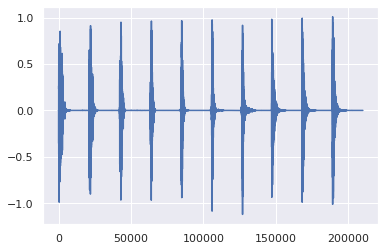

In [195]:
plot_and_hear(mix_drum2)


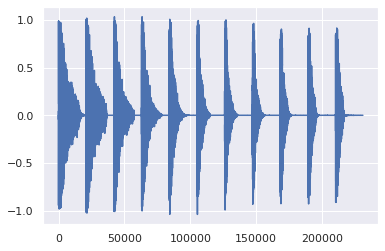

In [199]:
plot_and_hear(mix_drum)


# ODE Interpolation

In [121]:
Fode = ForwardODESampling(model, sde)
ode_sampling = ODESampling(model, sde)

In [123]:
latent1_ode = Fode.predict(drum1, 300)
latent2_ode = Fode.predict(drum2, 300)

In [128]:
mix_drum_ode = torch.cat([ode_sampling.predict(create_latent_mix(k*0.1, latent1_ode, latent2_ode), 300) for k in range(10)], axis=1)

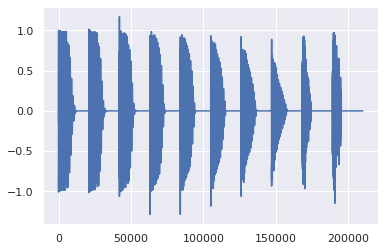

In [129]:
plot_and_hear(mix_drum_ode)
